# Assignment 1 - Part 2

<div class="alert alert-block alert-warning">
    Below we import <a href="https://github.com/HIPS/autograd">autograd</a>. If you get an error saying you don't have it, you will need to install it with pip, using
<pre>
pip install autograd
</pre>
</div>

In [346]:
import  autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian

## Newton's Method

We want to approximate solutions of nonlinear equation in __two variables__ using Newton's method.

Newton's method is implemented below.

Implement a stopping criterion. That is, given some tolerance $TOL$, end the method when $\mathbf{x}^k:=(x_1^k,x_2^k)$ satisfies $\|F(\mathbf{x}^k)\|_2\le TOL$ or $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2\le TOL$.

Provide numerial evidence that your code works as it should by printing the values of $\|F(\mathbf{x}^k)\|_2$ for each iteration, and by making a plot of $\|F(\mathbf{x}^k)\|_2$, $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2$, for all $k$.

Now, verify numerically the convergence is quadratic. You will need a reference solution, and one can do this in two ways:

 - Consider a problem for which you know an exact solution, and use said solution as a reference solution,
 - or for your problem, should you not know a solution, use the method to obtain an extremely accurate result which you use as a reference solution

[1.0020680343369088,
 1.003111723477662,
 1.004689294242083,
 1.0070826084397848,
 1.0107328136162643,
 1.0163422291520503,
 1.0250533231399768,
 1.0387720542382335,
 1.0607626119825673,
 1.0967363033047832,
 1.156729347014025,
 1.2576086937938924,
 1.4223586061313234,
 1.657351381622555,
 1.885964672706193,
 1.987160713715409,
 1.9997779425331899]

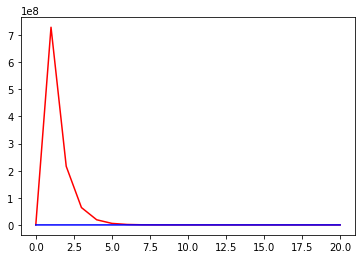

In [347]:
# A er en liste med norm av elementene Fx^0, Fx^1, ..., Fx^k...
# B er en liste med norm av differansene x^k+1-x^k, k=0,1,2,...
A = []
B = []
x_approx = []
def newtonsMethod(F, x0, maxIter=50, TOL=1.0e-20):
    # Implementation of Newton's root finding method.
    # F - the function you wish to find the root for,
    # x0 - initial guess,
    # maxIter - maximum number of iterations.
    DF = jacobian(F)
    x1 = x0
    for n in range(0, maxIter):
        x0 = x1
        J = DF(x0)
        Fx = F(x0)
        x1 = x1 - np.linalg.solve(J,Fx)
        A.append((np.linalg.norm(Fx)))
        B.append((np.linalg.norm(x1-x0)))
        x_approx.append(x1)
        if (np.linalg.norm(Fx)<= TOL):
            break
        if (np.linalg.norm(x1-x0)<= TOL):
            break
    return x1, A, B

#y the list of approximated values, while sol is the actual solution.
# q is the ratio of convergence, while e is list of "errors".
def rate(y, sol):
    q = []
    e = [np.linalg.norm(x - sol) for x in y]
    for n in range(1, len(e)-3, 1):
        q.append(np.log(e[n+1]/e[n])/np.log(e[n]/e[n-1]))
    return q

def f(x):
    return np.array([x[0]-x[1]+3,x[1]**3-27])

newtonsMethod(f,np.array([0.1,0.1]),maxIter=50, TOL=1.0e-20)
plt.plot(A, "r", len(A))
plt.plot(B, "b", len(B))
plt.show

rate(x_approx, [0,3])


We see from the printed values of $q$ that the rate of converges approaches $2$.

## Linear systems

Consider the linear system 
	\begin{equation*}
	A \mathbf{u} = \mathbf{f},
	\end{equation*}
where $A$ is a finite-difference discretization of the 2D Laplacian, this is a block tridiagonal matrix, implemented in the code below, and $\mathbf{f}$ is the vector with all components equal to one.

In [348]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy import linalg

# Creating the 2D laplacian matrix
nx, ny = 10, 10
N  = nx*ny
main_diag = np.ones(N)*-4.0
side_diag = np.ones(N-1)
side_diag[np.arange(1,N)%4==0] = 0
up_down_diag = np.ones(N-3)
diagonals = [main_diag,side_diag,side_diag,up_down_diag,up_down_diag]
laplacian = sparse.diags(diagonals, [0, -1, 1,nx,-nx])
print(laplacian*np.eye(N))

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]


We will now approximate the solution of this linear system using some different iteration methods of the type 
	\begin{equation*}
		A_1 \mathbf{u}^{(k+1)} = A_2 \mathbf{u}^{(k)}+\mathbf{f},
	\end{equation*}
	where $A = A_1 - A_2$ with $|A_1|\ne0$. The way we choose the matrices $A_1$ and $A_2$ depends upon the method. We will use the following iterative methods to calculate approximate solutions to $\mathbf{u}$:

a) Jacobi ($A_1 = A_d$).

b) Forward Gauss-Seidel ($A_1 = A_d-A_l$).

c) Successive over relaxation ($A_1 = A_d-\omega A_l$, where you can choose the value of $\omega\in (0,1)$).

Here $A = A_d - A_l - A_u$, where

- $A_d$ is the diagonal of $A$,
- $A_l$ is $-$(strictly lower triangular part of $A$),
- $A_u$ is $-$(strictly upper triangular part of $A$).

Consider the residual vector $\mathbf{r}^k:=\mathbf{f}-A\mathbf{u}^k$. We fix $nx=ny=10$ and $N=100$. For each of the above, you should:

i) Compare the convergence of each method. Submit  a semi-log plot of the $2$-norm of the relative residual $\frac{ \|\mathbf{r}^k\|_2 }{ \| \mathbf{r}^0\|_2 }$ versus the number of iterations. Plot all the methods in the same plot for comparison.
Experiment choosing different values of $\omega$ in the SOR method, try to find a value that gives you optimal convergence for this problem.


<function matplotlib.pyplot.show(*args, **kw)>

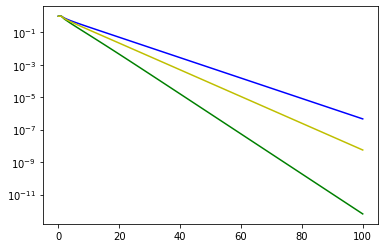

In [349]:
"""
$I let \omega\in[0,1]$ instead of $(0,1)$ which
makes $\omega=0$ give us the Jacobi method and
$\omega=1$ gives us Forward Gauss-Seidel.
"""
def SOR(A, f, u0, w, TOL, maxIter = 100):
    rk = [f - np.matmul(A,u0)]
    rel_rest = [1]
    uk = u0
    for i in range(0, maxIter):
        A1 = np.diag(np.diag(A))+w*(np.tril(A,-1))
        A2 = (A1-A)
        rk.append(f - np.matmul(A,uk))
        rel_rest.append(np.linalg.norm(rk[i+1])/(np.linalg.norm(rk[0])))
        uk = np.linalg.solve(A1,np.matmul(A2,uk)+f)
    return uk, rel_rest

uk1, rel_rest1 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 0, 1)
uk2, rel_rest2 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 1, 1)
uk3, rel_rest3 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 0.5, 1)

plt.semilogy(rel_rest1, 'b')
plt.semilogy(rel_rest2, 'g')
plt.semilogy(rel_rest3, 'y')
plt.show

ii) Implement a stopping criterion for the three methods as you have done for the Newton method. Record the relative time each method takes per iteration, and the rime needed to obtain a norm of the relative residual below toleances  $TOL=1e-7$ and $TOL=1e-14$. Make a table with the results for each method.

Method                  TOL = 1.0e-7    TOL = 1.0e-14
--------------------  --------------  ---------------
Jacobi Total             0.0340612        0.0392458
Jacobi Average           0.000340612      0.000392458
Gauss-Seidel Total       0.0172138        0.0296414
Gauss-Seidel Average     0.00029176       0.000296414
SOR Total                0.010293         0.0192702
SOR Average              0.000311909      0.000296464


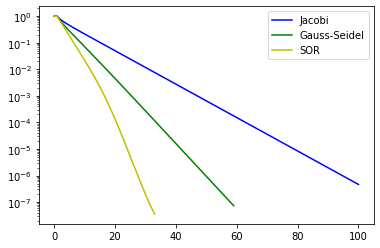

In [350]:
import time
from tabulate import tabulate
"""
As above I define a general function for SOR such that edgecases w=0,1 gives us the two other methods.
I decided not to have any time measurement inside the function.
"""
def SOR(A, f, u0, w, TOL, maxIter = 100):
    rk = [f - np.matmul(A,u0)]
    rel_rest = [1]
    uk = u0
    for i in range(0, maxIter):
        A1 = np.diag(np.diag(A))+w*(np.tril(A,-1))
        A2 = (A1-A)
        rk.append(f - np.matmul(A,uk))
        rel_rest.append(np.linalg.norm(rk[i+1])/(np.linalg.norm(rk[0])))
        uk = np.linalg.solve(A1,np.matmul(A2,uk)+f)
        if rel_rest[i] <= TOL:
            break
    return uk, rel_rest
# Here I time the program. I measure how long it takes to run the entire method and find the average per iteration
# by dividing by the number of iterations run by simply using the length of the relative rest array.
start_time = time.time()
uk4, rel_rest4 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 0, 1.0e-7)
time4 = (time.time() - start_time)

start_time = time.time()
uk5, rel_rest5 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 1, 1.0e-7)
time5 = (time.time() - start_time)

start_time = time.time()
uk6, rel_rest6 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 1.4, 1.0e-7)
time6 = (time.time() - start_time)

uk7, rel_rest7 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 0, 1.0e-14)
time7 = (time.time() - start_time)

start_time = time.time()
uk8, rel_rest8 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 1, 1.0e-14)
time8 = (time.time() - start_time)

start_time = time.time()
uk9, rel_rest9 = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), 1.4, 1.0e-14)
time9 = (time.time() - start_time)

plt.semilogy(rel_rest4, 'b', label = 'Jacobi')
plt.semilogy(rel_rest5, 'g', label = 'Gauss-Seidel')
plt.semilogy(rel_rest6, 'y', label = 'SOR')
plt.legend()

table = [
    ["Jacobi Total", time4, time7],
    ["Jacobi Average", time4/(len(rel_rest4)-1), time7/(len(rel_rest7)-1)],
    ["Gauss-Seidel Total", time5, time8],
    ["Gauss-Seidel Average", time5/(len(rel_rest5)-1), time8/(len(rel_rest8)-1)],
    ["SOR Total", time6, time9],
    ["SOR Average", time6/(len(rel_rest6)-1), time9/(len(rel_rest9)-1)]
]
print(tabulate(table, headers = ["Method", "TOL = 1.0e-7", "TOL = 1.0e-14" ]))

iii) Calculate the spectral radius of $A_1^{-1}A_2$ and see how that relates to convergence of the method. Make a semi-log plot for comparison. 

<div class="alert alert-block alert-info">
<b>Hint:</b> Python's 
    <pre>numpy.linalg.eigvals(A)</pre>
function returns the eigenvalues of $A$.
</div>

<function matplotlib.pyplot.show(*args, **kw)>

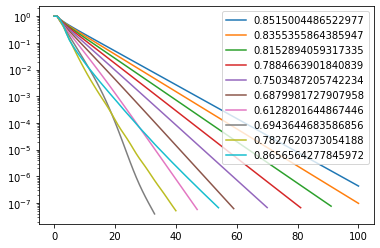

In [351]:
def spectral_radius(w):
    A = laplacian*np.eye(N)
    A1 = np.diag(np.diag(A))+w*(np.tril(A,-1))
    A2 = (A1-A)
    eig = np.linalg.eigvals(np.matmul(np.linalg.inv(A1), A2))
    radius = np.linalg.norm(eig, np.inf)
    return radius

def test(step):
    r = []
    j = 0.01
    omega = []
    rest = []
    while j <= 2:
        uj, rel_rest_j = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), j, 1.0e-7)
        r.append(spectral_radius(j))
        j += step
        omega.append(j)
        plt.semilogy(rel_rest_j, label = (spectral_radius(j)))
        
    return r, omega
r, omega = test(0.2)

plt.legend(loc = 'best')
plt.show

We know a matrix $T$ is convergent iff its spectral radius $\rho(T)$ is less than $1$. We should also expect faster convergence with a smaller radius. From the plot above we see that for values of $\omega \in (0,2)$ the spectral
radius is smaller than one, and our relative rests seems to converge to $0$, indicating convergence of the solution.

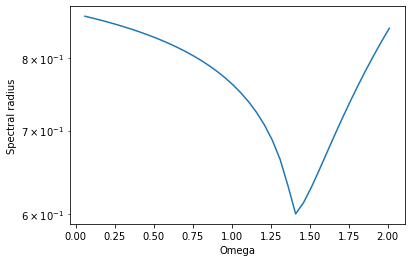

In [352]:
# We plot omega against the spectral radius to find which omega gives the lowest radius.
def test_1(step):
    r = []
    j = 0.01
    omega = []
    rest = []
    while j <= 2:
        uj, rel_rest_j = SOR(laplacian*np.eye(N), np.ones(100), np.ones(100), j, 1.0e-7)
        r.append(spectral_radius(j))
        j += step
        omega.append(j)
    return r, omega
r_1, omega_1 = test_1(0.05)

plt.semilogy(omega_1, r_1)
plt.xlabel('Omega')
plt.ylabel('Spectral radius')
plt.show()
# The plot indicates that omega around 1.4 gives the lowest spectral radius, so we choose omega = 1.4 
# for our computations in the preceding exercise to compare the relative time of the methods.

<function matplotlib.pyplot.show(*args, **kw)>

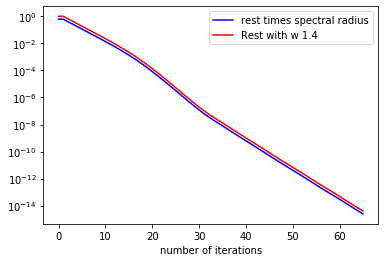

In [353]:
new = [x * (spectral_radius(1.4)) for x in rel_rest9]
plt.semilogy(new, 'b', label = 'rest times spectral radius')
plt.semilogy(rel_rest9, 'r', label = 'Rest with w 1.4')
plt.legend(loc = 'best')
plt.xlabel('number of iterations')
plt.show

The problem description asks for a plot comparing for comparison and the relation between the spectral radius and convergence. I did not entirely understand what the problem is asking us to plot for comparison, so I have tried to plot the relative residues and comparing their plots to their respective spectral radi to get some intuition of the relation between the two. The way we have chosen $\omega$, all spectral radi are smaller than one, which ensures convergence. 